# Kendrick Mass Filter - Parameter Exploration
 __Authors:__ Ricardo R. da Silva (ridasilva@ucsd.edu), Madeleine Ernst (mernst@ucsd.edu), Alan K. Jarmusch (ajarmusch@ucsd.edu) <br>
 __Verion:__ 1.0 (Prior to Submission of Manuscript) <br>
 __Date of Last Revision:__ 06-21-2018 <br>
 
**Description**: Kendrick mass is the mass-to-charge (*m/z*) of each ion rescaled to an integer value of a given unit repeat. The defect between the Kendrick scaled *m/z* and the integer Kendrick mass value, i.e. Kendrick mass defect (KMD), is similar between homologous compounds. The Kendrick Mass Filter (MDF) is used to perform selection and removal of data centered around a user-defined KMD, with addtional restrictions on the elution time and presence of possibly multiple homologous compounds eluting together. This notebook aids user-defined parameter selection of KMF by exploring the effects of Kendrick mass filtering parameters. 

**Input**: <br>
<ul>
<li>**Feature table(s)**: (.csv) files with features in columns and samples in rows. Feature IDs are provided in the column names in the following format: "mz;RT". The first column must contain sample names. </li>
</ul> <br>
**Output**: <br>
<ul>
<li>**Summary tables**: (.csv) files containing Kendrick mass filtered parameter optimization output data.  </li>
<li>**Plots**: (.pdf) files as well as interactive plots aiding parameter optimization. </li>
</ul> <br> 
**Dependencies**: R version 3.4.2 (2017-09-28) and packages: doMC_1.3.5, iterators_1.0.9, foreach_1.4.4, VennDiagram_1.6.20, futile.logger_1.4.3, viridis_0.4.1, viridisLite_0.2.0, gridExtra_2.3, htmlwidgets_1.2, plotly_4.7.1, ggplot2_2.2.1.     

load libraries

In [1]:
library(plotly)
library(htmlwidgets)
library(grid)
library(gridExtra)
library(viridis)
library(VennDiagram)
library(doMC)
library(IRdisplay)

Loading required package: ggplot2

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

Warning message:
“package ‘htmlwidgets’ was built under R version 3.4.4”Loading required package: viridisLite
Warning message:
“package ‘VennDiagram’ was built under R version 3.4.4”Loading required package: futile.logger
Warning message:
“package ‘doMC’ was built under R version 3.4.3”Loading required package: foreach
Warning message:
“package ‘foreach’ was built under R version 3.4.3”Loading required package: iterators
Warning message:
“package ‘iterators’ was built under R version 3.4.3”Loading required package: parallel
Warning message:
“package ‘IRdisplay’ was built under R version 3.4.4”

load Kendrick Mass Filter source function

In [2]:
source("kendrick.mass.filter_new_all_datamatrix_terminologyupdate.R")

Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: ‘Hmisc’

The following object is masked from ‘package:gridExtra’:

    combine

The following object is masked from ‘package:plotly’:

    subplot

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units

Loading required package: graph
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following object is masked from ‘package:Hmisc’:

    combine

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

 

# Define Parameter Values to Explore

Define Kendrick Mass Defect (KMD) parameter values to explore:

In [3]:
kend_mass <- c(0.001, 0.0015, 0.002, 0.0025, 0.005, 0.0067, 0.0075, 0.01,
                   0.0125, 0.015, 0.02, 0.025, 0.033, 0.05, 0.067, 0.1)
kend_mass

[1] 0.0010 0.0015 0.0020 0.0025 0.0050 0.0067 0.0075 0.0100 0.0125 0.0150
[11] 0.0200 0.0250 0.0330 0.0500 0.0670 0.1000

Define Retention Time (RT) parameter values to explore:

In [4]:
rt <- c(seq(from = 1, to = 2, by = 0.25), seq(from = 0.1, to = 0.9, by = 0.1), seq(from=0.15, to=0.25, by = 0.05))
rt

[1] 1.00 1.25 1.50 1.75 2.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 0.15
[16] 0.20 0.25

Define Number of Observations (NOS) parameter values to explore

In [5]:
conn_nun <- 1:5
conn_nun

[1] 1 2 3 4 5

Create table of all parameter combinations

In [6]:
all_comb <- expand.grid(kend_mass, conn_nun, rt)
head(all_comb)

Var1,Var2,Var3
0.0010,1,1
0.0015,1,1
0.0020,1,1
0.0025,1,1
0.0050,1,1
0.0067,1,1


# Iteratively Perform Kendrick Mass Filtering of Data using Defined Parameter Values

Specify input files (samples in rows and variables in columns)

In [17]:
plasma_fn = "all17K/tab17plasma.csv"
swabextract_fn = "all17K/tab17swabextract.csv"
peg_fn = "all17K/tab17PEG.csv"
plasmaspikedswab_fn = "all17K/tab17plasmaspikedswab.csv"

In [18]:
# Iteratively Perform KMF on Data (time parallel computation)
registerDoMC()
all_comb_ans3 <- list()
system.time(all_comb_ans3 <- foreach(i=1:nrow(all_comb)) %dopar%{
            composition.analysis(feature_matrix = plasmaspikedswab_fn, 
                                                       polymer = c("polyethylene_glycol_other_C2H4O1"),
                                                       mass_defect_parameter = all_comb[i,1],
                                                       retention_time = all_comb[i,3],
                                                       connections_min_number = all_comb[i,2],
                                                       comp_list = c(plasma_fn, 
                                                                     peg_fn, 
                                                                     swabextract_fn, 
                                                                     plasmaspikedswab_fn))})
# Origin of the extracted features to all parameter combinations
all_comb_tab <- lapply(all_comb_ans3, function(x) x$summary$polyethylene_glycol_other_C2H4O1)
all_comb_tab <- do.call(rbind, all_comb_tab)
all_comb_tab <- as.data.frame(all_comb_tab)
head(all_comb_tab)

    user   system  elapsed 
1673.398   17.966  595.142 

p,mass_defect_parameter,retention_time,connections_min_number,features_before_filtering,features_after_filtering,inputAfterFilterVStab17plasma,inputAfterFilterVStab17PEG,inputAfterFilterVStab17swabextract,inputAfterFilterVStab17plasmaspikedswab,features_after_filtering_wgraph,inputAfterFilterAndGraphVStab17plasma,inputAfterFilterAndGraphVStab17PEG,inputAfterFilterAndGraphVStab17swabextract,inputAfterFilterAndGraphVStab17plasmaspikedswab
polyethylene_glycol_other_C2H4O1,0.0010,1,1,1191,1015,315,77,380,1015,1015,315,77,380,1015
polyethylene_glycol_other_C2H4O1,0.0015,1,1,1191,936,313,67,322,936,936,313,67,322,936
polyethylene_glycol_other_C2H4O1,0.0020,1,1,1191,880,304,55,285,880,880,304,55,285,880
polyethylene_glycol_other_C2H4O1,0.0025,1,1,1191,816,293,44,249,816,816,293,44,249,816
polyethylene_glycol_other_C2H4O1,0.0050,1,1,1191,690,290,29,160,690,690,290,29,160,690
polyethylene_glycol_other_C2H4O1,0.0067,1,1,1191,640,284,26,130,640,640,284,26,130,640


Write output of iteratively performing KMF on data to file

In [19]:
write.csv(all_comb_tab,"20180611_Output_Table_KendrickMassFiter_TestingMultipleParameters.csv", row.names=FALSE)

# Plot Kendrick Mass Filtering Results to aid Kendrick Mass Filter Parameter Optimization

load data matrices specified above 

In [20]:
# Load the matrices to perform comparison
plasma = read.csv(plasma_fn, check.names=FALSE)
swabextract = read.csv(swabextract_fn, check.names=FALSE)
peg = read.csv(peg_fn, check.names=FALSE)
plasmaspikedswab = read.csv(plasmaspikedswab_fn, check.names=FALSE)

In [21]:
# Origin of the extracted features to all parameter combinations
prop_polymer <- lapply(all_comb_ans3, function(x)
                                        c(length(x$data$polyethylene_glycol_other_C2H4O1),
                                          sum(colnames(plasmaspikedswab)[-1][x$data$polyethylene_glycol_other_C2H4O1] %in% colnames(plasma)),
                                          sum(colnames(plasmaspikedswab)[-1][x$data$polyethylene_glycol_other_C2H4O1] %in% colnames(swabextract)),
                                          sum(colnames(plasmaspikedswab)[-1][x$data$polyethylene_glycol_other_C2H4O1] %in% colnames(peg)),
                                          sum(colnames(plasmaspikedswab)[-1][x$data$polyethylene_glycol_other_C2H4O1] %in% colnames(swabextract) & colnames(plasmaspikedswab)[-1][x$data$polyethylene_glycol_other_C2H4O1] %in% colnames(peg))
                                          )
)
    prop_polymer <- do.call(rbind, prop_polymer)
    colnames(prop_polymer) <- c('Plasma_spiked_SwabExtract', 'plasma', 'swabextract', 'peg', 'plasma_spiked_peg')
    prop_polymer <- as.data.frame(prop_polymer)
    head(prop_polymer)

Plasma_spiked_SwabExtract,plasma,swabextract,peg,plasma_spiked_peg
176,4,141,30,29
255,6,199,40,38
311,15,236,52,50
375,26,272,63,61
501,29,361,78,71
551,35,391,81,74


In [22]:
# Compute Scoring (plasma/PEG features) for plot
prop_ratio <- prop_polymer[,"plasma"] / prop_polymer[,"peg"]
PEG_optimization <- cbind(prop_polymer,prop_ratio)
    head(PEG_optimization)
write.csv(PEG_optimization, "20180611_Output_Table_PEGoptimization.csv", row.names=FALSE)

Plasma_spiked_SwabExtract,plasma,swabextract,peg,plasma_spiked_peg,prop_ratio
176,4,141,30,29,0.1333333
255,6,199,40,38,0.1500000
311,15,236,52,50,0.2884615
375,26,272,63,61,0.4126984
501,29,361,78,71,0.3717949
551,35,391,81,74,0.4320988


## Static Version of Plot for defining optimal parameter combinations

Warning message:
“Removed 57 rows containing missing values (geom_point).”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Plasma + Swab Extract Features Filtered' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Plasma + Swab Extract Features Filtered' not found in PostScript font database”Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Plasma + Swab Extract Features Filtered' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Plasma + Swab Extract Features Filtered' not found in PostScript font database”Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Plasma + Swab Extract Features Filtered' not found in PostScript font database”Saving 7 x 7 in image
Warning message:
“Remov

ERROR: Error in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, : invalid font type


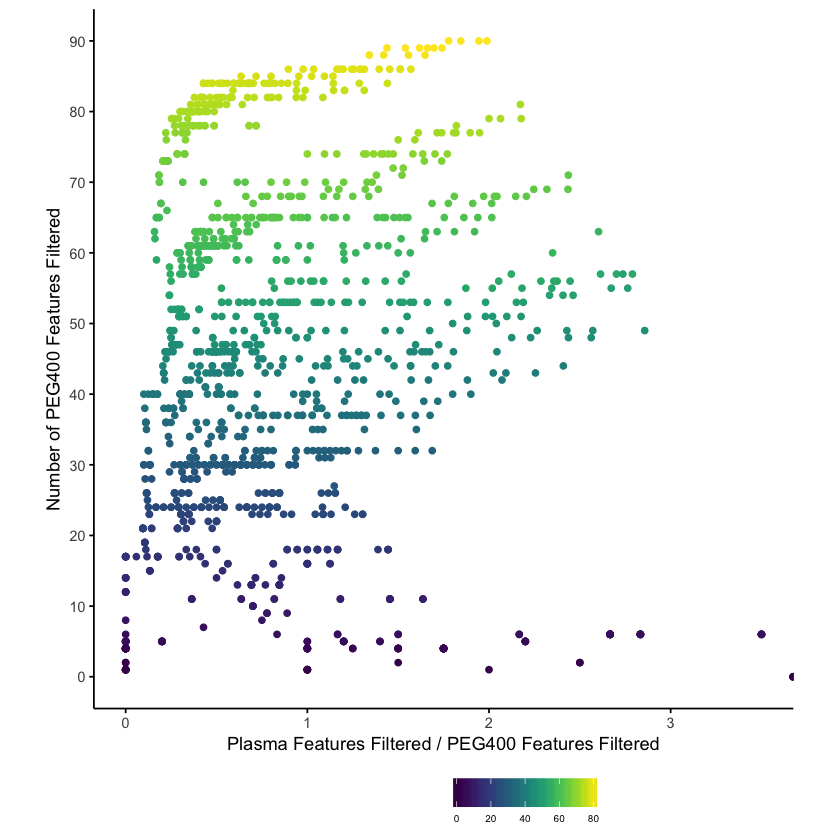

In [23]:
static_plot <- ggplot(prop_polymer, aes(x=prop_ratio, y=peg, colour=plasma_spiked_peg))+
    geom_point()+    
    scale_y_continuous(breaks=seq(0,100,10)) +
        xlab("Plasma Features Filtered / PEG400 Features Filtered") +
        ylab("Number of PEG400 Features Filtered") +
    scale_color_viridis() +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("Plasma + Swab Extract Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(static_plot)
ggsave("ParameterExplorationPlot.pdf")

## Interactive Version of Plot for defining optimal parameter combinations

In [24]:
p <- plot_ly(type="scatter",mode="markers", data = prop_polymer, 
                              x = ~prop_ratio, y = ~peg, color=~plasma_spiked_peg)
saveWidget(p, "plot_ly.html")
display_html("<iframe width='100%' height='550' src='plot_ly.html'></iframe>")

Warning message:
“Ignoring 57 observations”

** Explore values to determine the Kendrick Mass Filtering parameters:** <br>

Here, we want to maximize the filtering of PEG 400, while minimizing the number of plasma features filtered, corresponding to the leftmost, uppermost grouping in the plot above. To retrieve x and y values, hover the mouse over the interactive plot.

In [25]:
prop_polymer[which(round(prop_ratio, 1)==0.4 & prop_polymer[,'peg']==82),]

,Plasma_spiked_SwabExtract,plasma,swabextract,peg,plasma_spiked_peg
888,591,34,423,82,75
889,603,34,429,82,75
890,609,35,431,82,75
967,557,31,401,82,75
1047,560,34,401,82,75


Retrieve parameters

In [26]:
all_comb_tab[which(round(prop_ratio, 1)==0.4 & prop_polymer[,'peg']==82),]

,p,mass_defect_parameter,retention_time,connections_min_number,features_before_filtering,features_after_filtering,inputAfterFilterVStab17plasma,inputAfterFilterVStab17PEG,inputAfterFilterVStab17swabextract,inputAfterFilterVStab17plasmaspikedswab,features_after_filtering_wgraph,inputAfterFilterAndGraphVStab17plasma,inputAfterFilterAndGraphVStab17PEG,inputAfterFilterAndGraphVStab17swabextract,inputAfterFilterAndGraphVStab17plasmaspikedswab
888,polyethylene_glycol_other_C2H4O1,0.0100,0.7,1,1191,600,285,25,98,600,600,285,25,98,600
889,polyethylene_glycol_other_C2H4O1,0.0125,0.7,1,1191,588,285,25,92,588,588,285,25,92,588
890,polyethylene_glycol_other_C2H4O1,0.0150,0.7,1,1191,582,284,25,90,582,582,284,25,90,582
967,polyethylene_glycol_other_C2H4O1,0.0075,0.8,1,1191,634,288,25,120,634,634,288,25,120,634
1047,polyethylene_glycol_other_C2H4O1,0.0075,0.9,1,1191,631,285,25,120,631,631,285,25,120,631


# Explore KMF Parameters and Filtering Behavior - KMD & NOS

Here, we fixed the retention time based on the parameters indicated above

In [27]:
nun_peaks_extracted = cbind(prop_polymer[all_comb_tab[,'retention_time']== 0.8,],
                            all_comb_tab[all_comb_tab[,'retention_time']== 0.8,]
                            )
colnames(nun_peaks_extracted)[1] <- 'feat_extracted'
nun_peaks_extracted$connections_min_number <- as.factor(nun_peaks_extracted$connections_min_number)
nun_peaks_extracted <- cbind(nun_peaks_extracted$plasma/nun_peaks_extracted$peg,nun_peaks_extracted)
colnames(nun_peaks_extracted)[1] <- 'prop_ratio'
head(nun_peaks_extracted)

,prop_ratio,feat_extracted,plasma,swabextract,peg,plasma_spiked_peg,p,mass_defect_parameter,retention_time,connections_min_number,⋯,features_after_filtering,inputAfterFilterVStab17plasma,inputAfterFilterVStab17PEG,inputAfterFilterVStab17swabextract,inputAfterFilterVStab17plasmaspikedswab,features_after_filtering_wgraph,inputAfterFilterAndGraphVStab17plasma,inputAfterFilterAndGraphVStab17PEG,inputAfterFilterAndGraphVStab17swabextract,inputAfterFilterAndGraphVStab17plasmaspikedswab
961,0.1000000,174,3,141,30,29,polyethylene_glycol_other_C2H4O1,0.0010,0.8,1,⋯,1017,316,77,380,1017,1017,316,77,380,1017
962,0.1000000,252,4,199,40,38,polyethylene_glycol_other_C2H4O1,0.0015,0.8,1,⋯,939,315,67,322,939,939,315,67,322,939
963,0.2500000,307,13,235,52,50,polyethylene_glycol_other_C2H4O1,0.0020,0.8,1,⋯,884,306,55,286,884,884,306,55,286,884
964,0.3809524,371,24,271,63,61,polyethylene_glycol_other_C2H4O1,0.0025,0.8,1,⋯,820,295,44,250,820,820,295,44,250,820
965,0.3205128,496,25,361,78,71,polyethylene_glycol_other_C2H4O1,0.0050,0.8,1,⋯,695,294,29,160,695,695,294,29,160,695
966,0.3580247,543,29,391,81,74,polyethylene_glycol_other_C2H4O1,0.0067,0.8,1,⋯,648,290,26,130,648,648,290,26,130,648


write table to file

In [28]:
write.csv(nun_peaks_extracted,"20180611_Output_Table_KMFEvaluatedwithPEGparameters.csv", row.names=FALSE)

plot results

Saving 10.5 x 10.5 in image


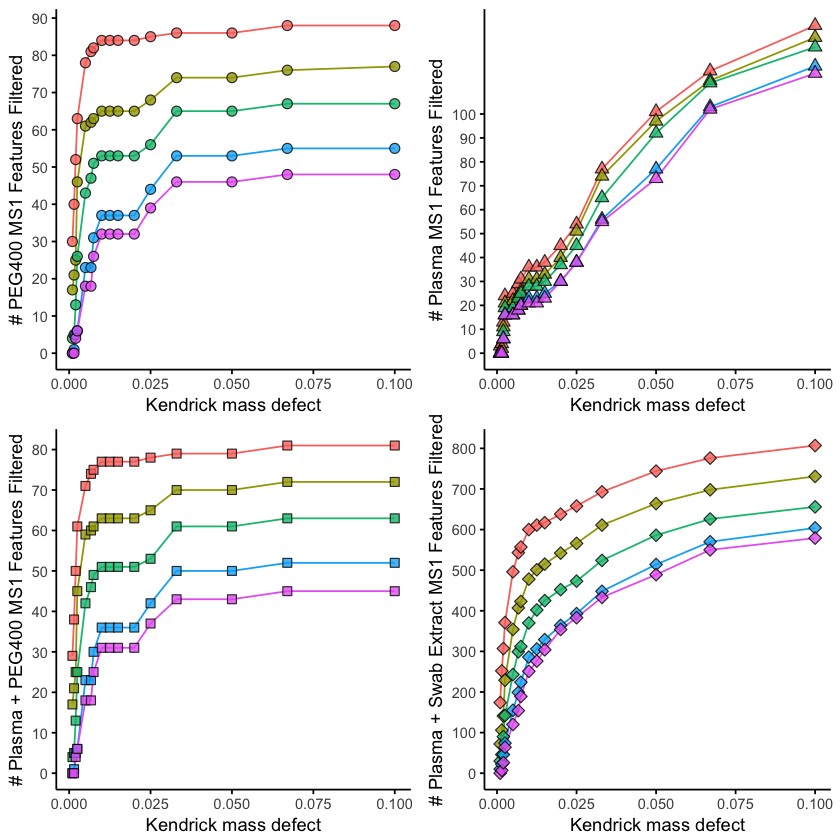

In [29]:
a <- ggplot(nun_peaks_extracted, aes(x=mass_defect_parameter, y=peg, colour=connections_min_number)) + 
    scale_y_continuous(breaks=seq(0,100,10)) +
        xlab("Kendrick mass defect") +
        ylab("# PEG400 MS1 Features Filtered") +
    geom_line() +          
        geom_point(aes(fill=connections_min_number), alpha=0.8, colour="black", pch=21, size=2.5) +
    
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=8))


b <- ggplot(nun_peaks_extracted, aes(x=mass_defect_parameter, y=plasma, colour=connections_min_number)) +   
    scale_y_continuous(breaks=seq(0,100,10)) +
        xlab("Kendrick mass defect") +
        ylab("# Plasma MS1 Features Filtered") +
    geom_line() +          
        geom_point(aes(fill=connections_min_number), alpha=0.8, colour="black", pch=24, size=2.5) +
    
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=8))

c <- ggplot(nun_peaks_extracted, aes(x=mass_defect_parameter, y=plasma_spiked_peg, colour=connections_min_number)) + 
    scale_y_continuous(breaks=seq(0,200,10)) +
        xlab("Kendrick mass defect") +
        ylab("# Plasma + PEG400 MS1 Features Filtered") +
    geom_line() +          
        geom_point(aes(fill=connections_min_number), alpha=0.8, colour="black", pch=22, size=2.5) +
    
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=8))

d <- ggplot(nun_peaks_extracted, aes(x=mass_defect_parameter, y=feat_extracted, colour=connections_min_number)) +  
    scale_y_continuous(breaks=seq(0,1200,100)) +
        xlab("Kendrick mass defect") +
        ylab("# Plasma + Swab Extract MS1 Features Filtered") +
    geom_line() +          
        geom_point(aes(fill=connections_min_number), alpha=0.8, colour="black", pch=23, size=2.5) +
    
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=8))

grid.arrange(a,b,c,d,ncol=2, nrow=2)
plot_all <- arrangeGrob(a,b,c,d,ncol=2, nrow=2)
ggsave("20180611_KMF_Figure_KMDandNOS.pdf", plot_all, scale=1.5)

# Explore KMF Parameters and Filtering Behavior - RT & NOS

Here, we fixed the KMD based on the parameters indicated above

In [30]:
nun_peaks_extracted_RT = cbind(prop_polymer[all_comb_tab[,'mass_defect_parameter']==0.01,],
                            all_comb_tab[all_comb_tab[,'mass_defect_parameter']==0.01,]
                            )
colnames(nun_peaks_extracted_RT)[1] <- 'feat_extracted'
nun_peaks_extracted_RT$connections_min_number <- as.factor(nun_peaks_extracted_RT$connections_min_number)
nun_peaks_extracted_RT <- cbind(nun_peaks_extracted_RT$plasma/nun_peaks_extracted_RT$peg,nun_peaks_extracted_RT)
colnames(nun_peaks_extracted_RT)[1] <- 'prop_ratio'
head(nun_peaks_extracted_RT)

,prop_ratio,feat_extracted,plasma,swabextract,peg,plasma_spiked_peg,p,mass_defect_parameter,retention_time,connections_min_number,⋯,features_after_filtering,inputAfterFilterVStab17plasma,inputAfterFilterVStab17PEG,inputAfterFilterVStab17swabextract,inputAfterFilterVStab17plasmaspikedswab,features_after_filtering_wgraph,inputAfterFilterAndGraphVStab17plasma,inputAfterFilterAndGraphVStab17PEG,inputAfterFilterAndGraphVStab17swabextract,inputAfterFilterAndGraphVStab17plasmaspikedswab
8,0.5238095,611,44,426,84,77,polyethylene_glycol_other_C2H4O1,0.01,1.00,1,⋯,580,275,23,95,580,580,275,23,95,580
24,0.6153846,495,40,355,65,63,polyethylene_glycol_other_C2H4O1,0.01,1.00,2,⋯,580,275,23,95,580,696,279,42,166,696
40,0.6981132,393,37,280,53,51,polyethylene_glycol_other_C2H4O1,0.01,1.00,3,⋯,580,275,23,95,580,798,282,54,241,798
56,0.9459459,313,35,216,37,36,polyethylene_glycol_other_C2H4O1,0.01,1.00,4,⋯,580,275,23,95,580,878,284,70,305,878
72,0.7812500,258,25,186,32,31,polyethylene_glycol_other_C2H4O1,0.01,1.00,5,⋯,580,275,23,95,580,933,294,75,335,933
88,0.6190476,630,52,432,84,77,polyethylene_glycol_other_C2H4O1,0.01,1.25,1,⋯,561,267,23,89,561,561,267,23,89,561


plot results

Saving 10.5 x 10.5 in image


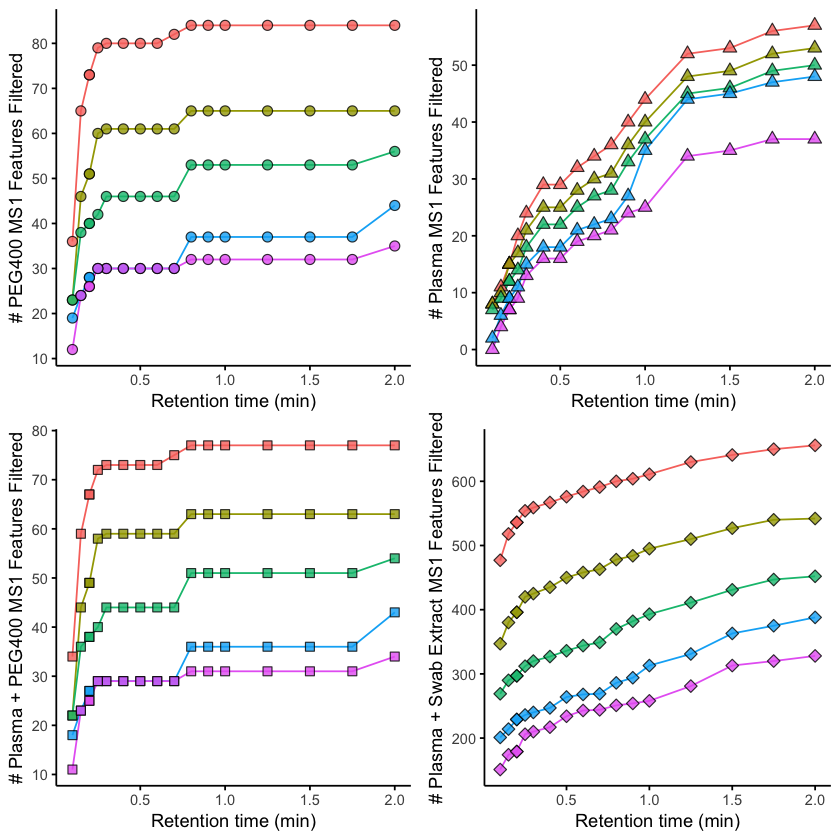

In [31]:
a <- ggplot(nun_peaks_extracted_RT, aes(x=retention_time, y=peg, colour=connections_min_number)) +  
    scale_y_continuous(breaks=seq(0,100,10)) +
        xlab("Retention time (min)") +
        ylab("# PEG400 MS1 Features Filtered") +
    geom_line() +          
        geom_point(aes(fill=connections_min_number), alpha=0.8, colour="black", pch=21, size=2.5) +
    
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=8))


b <- ggplot(nun_peaks_extracted_RT, aes(x=retention_time, y=plasma, colour=connections_min_number)) +
    scale_y_continuous(breaks=seq(0,100,10)) +
        xlab("Retention time (min)") +
        ylab("# Plasma MS1 Features Filtered") +
    geom_line() +          
        geom_point(aes(fill=connections_min_number), alpha=0.8, colour="black", pch=24, size=2.5) +
    
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=8))

c <- ggplot(nun_peaks_extracted_RT, aes(x=retention_time, y=plasma_spiked_peg, colour=connections_min_number)) +  
    scale_y_continuous(breaks=seq(0,200,10)) +
        xlab("Retention time (min)") +
        ylab("# Plasma + PEG400 MS1 Features Filtered") +
    geom_line() +          
        geom_point(aes(fill=connections_min_number), alpha=0.8, colour="black", pch=22, size=2.5) +
    
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=8))

d <- ggplot(nun_peaks_extracted_RT, aes(x=retention_time, y=feat_extracted, colour=connections_min_number)) +
    scale_y_continuous(breaks=seq(0,1200,100)) +
        xlab("Retention time (min)") +
        ylab("# Plasma + Swab Extract MS1 Features Filtered") +
    geom_line() +          
        geom_point(aes(fill=connections_min_number), alpha=0.8, colour="black", pch=23, size=2.5) +
    
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=8))

grid.arrange(a,b,c,d,ncol=2, nrow=2)
plot_all <- arrangeGrob(a,b,c,d,ncol=2, nrow=2)
ggsave("20180611_KMF_Figure_RTandNOS.pdf", plot_all, scale=1.5)

# Evaluate Kendrick Mass Filtering via the Scoring Value

The scoring value is based on the removal of plasma features / PEG 400

Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”Saving 10.5 x 10.5 in image
Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

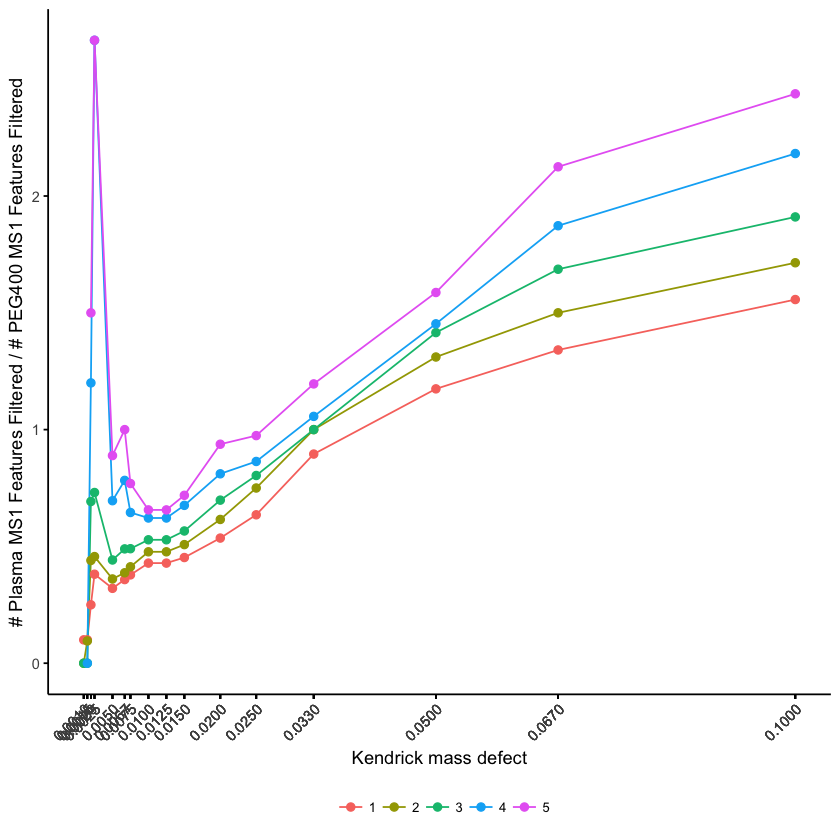

In [32]:
# RATIO (Optimation Plot) w/ Retention Time Parameter of 0.2 min
a <- ggplot(nun_peaks_extracted, aes(x=mass_defect_parameter, y=prop_ratio, colour=connections_min_number)) +
    scale_x_continuous(breaks=nun_peaks_extracted$mass_defect_parameter)+
        xlab("Kendrick mass defect") +
        ylab("# Plasma MS1 Features Filtered / # PEG400 MS1 Features Filtered") +
    geom_line() +          
        geom_point(aes(fill=connections_min_number), alpha=1, size=2) +
    
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
                  axis.text.x = element_text(angle = 45, hjust = 1),
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=8))
print(a)
ggsave("20180611_KMF_Figure_KMFScoring_KMD.pdf", a, scale=1.5)

Saving 10.5 x 10.5 in image


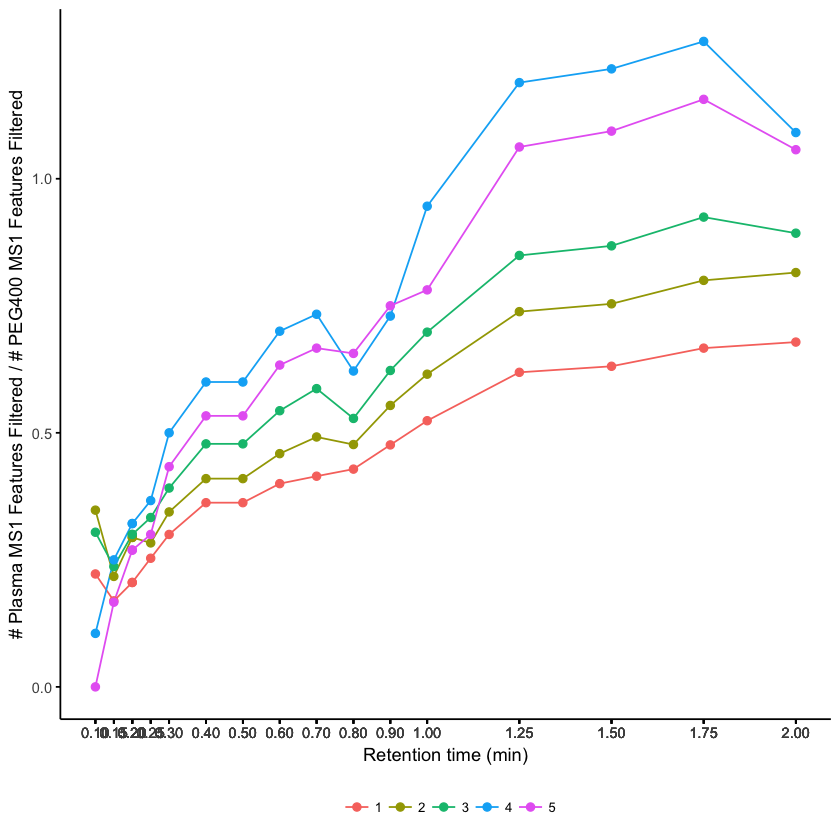

In [33]:
# RATIO (Optimation Plot) w/ Retention Time Parameter of 0.2 min
a <- ggplot(nun_peaks_extracted_RT, aes(x=retention_time, y=prop_ratio, colour=connections_min_number)) +
    #scale_y_continuous(breaks=seq(0,5,0.1)) +
    scale_x_continuous(breaks=nun_peaks_extracted_RT$retention_time)+
        xlab("Retention time (min)") +
        ylab("# Plasma MS1 Features Filtered / # PEG400 MS1 Features Filtered") +
    geom_line() +          
        geom_point(aes(fill=connections_min_number), alpha=1, size=2) +
    
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=8))
print(a)
ggsave("20180611_KMF_Figure_KMFScoring_RT.pdf", a, scale=1.5)